# Tuolumne Basin Timeseries Boxplots  
### Plot a timeseries of the following:
* Daily in situ snow depth from CDEC stations (TUM and DAN) 
* ICESat-2 SlideRule (ATL06-SR): ATL06-SR data is aggregated by acquisition date.     
* Airborne Snow Observatory, Inc (ASO) lidar snow depth, separate into two data types:
    * snow depth sampled from the ASO snow depth at the location of each ATL06-SR point  
    * snow depth aggregated using the entire lidar data (spanning the entire study area)


### Import necessary packages:

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from astropy.time import Time
import datetime
from rasterstats import zonal_stats
import pickle

In [2]:
%matplotlib inline

In [3]:
# plt.rcParams['figure.facecolor']='w'
# plt.rcParams['axes.facecolor']='w'
# plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [6]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [7]:
mpl_epoch = '1970-01-01'

In [8]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Create File Paths to Snow On ASO Data for Rasterstats Calculations:

In [9]:
aso_fn_winters = ['../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200413_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200522_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif']

In [10]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

### Load in the saved data:

In [11]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))
cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_895/3398378158.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_895/3398378158.py:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_895/3398378158.py:5: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))


### Remove outliers using a z-score filter and absolute value filter:

In [12]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [13]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) #& (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [14]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Write functions for aggregating ASO snow depth data:

In [15]:
# written by Hannah Besso, June 30, 2022

def build_stats(rasterstats):
    rasterstats = rasterstats[0]
    stats_dict = {'mean':rasterstats['mean'], 'iqr':(rasterstats['max']-rasterstats['min']), 'whishi':rasterstats['max'], 'whislo':rasterstats['min'], 'q1':rasterstats['percentile_25'], 'med':rasterstats['median'], 'q3':rasterstats['percentile_75'], 'count':rasterstats['count']}
    return stats_dict

def build_bp_stats(raster_list = None, region = None):
    dict_list = []
    pos = []
    count = []
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
        stats_dict = build_stats(rasterstats)
        dict_list.append(stats_dict)
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        pos.append((pd.to_datetime(date) - pd.to_datetime(mpl_epoch)).days)
        count.append(stats_dict['count'])

    count = np.array(count)
    return dict_list, pos, count

### Aggregate ASO snow depth data and calculate statistics:

In [16]:
stats_dict = build_bp_stats(aso_fn_winters, outline_gdf)

### Write function for plotting data:

In [25]:
# Function adapted from David Shean by Hannah Besso
# Allows for multiple levels of data to be plotted. Can just plot in situ snow depth, or can add any/all of the following:
# ICESat-2, sampled ASO, and full-site ASO

def boxplot_date_aso_all(df=None, col=None, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Tuolumne River basin above Hetch Hetchy, CA', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    if df is not None:
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = bp_alpha/bp_alpha.max()
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso is not None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(15,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, linestyle='--', label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    if df is not None:
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso is not None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
                    medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
                        medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
    if df is not None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            patch.set_edgecolor('None')
            patch.set_linewidth(0)
    if col_aso is not None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('#117733')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('#882255')
            patch.set_edgecolor('none')
            patch.set_alpha(0.5)
    ax.set_title(title, fontsize=24)
    
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if df is not None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            patch.set_edgecolor('None')
            patch.set_linewidth(0)
    if df is not None:
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            patch.set_color('k')  # or deeppink  
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=22)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    
    if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
        ax.set_xlabel('Water Year 2019 Acquisition Date', fontsize=22)
    else:
        ax.set_xlabel('Acquisition Date', fontsize=22)
    
    # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]
    
    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))
    
    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=1.5, which='major')
    ax.tick_params('both', length=5, width=1.5, which='minor')
    ax.legend(custom, custom_labels, loc='upper right', prop={'size':18}, fancybox=True, framealpha=0.5) #, fontsize=10
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

## Plot data for manuscript:

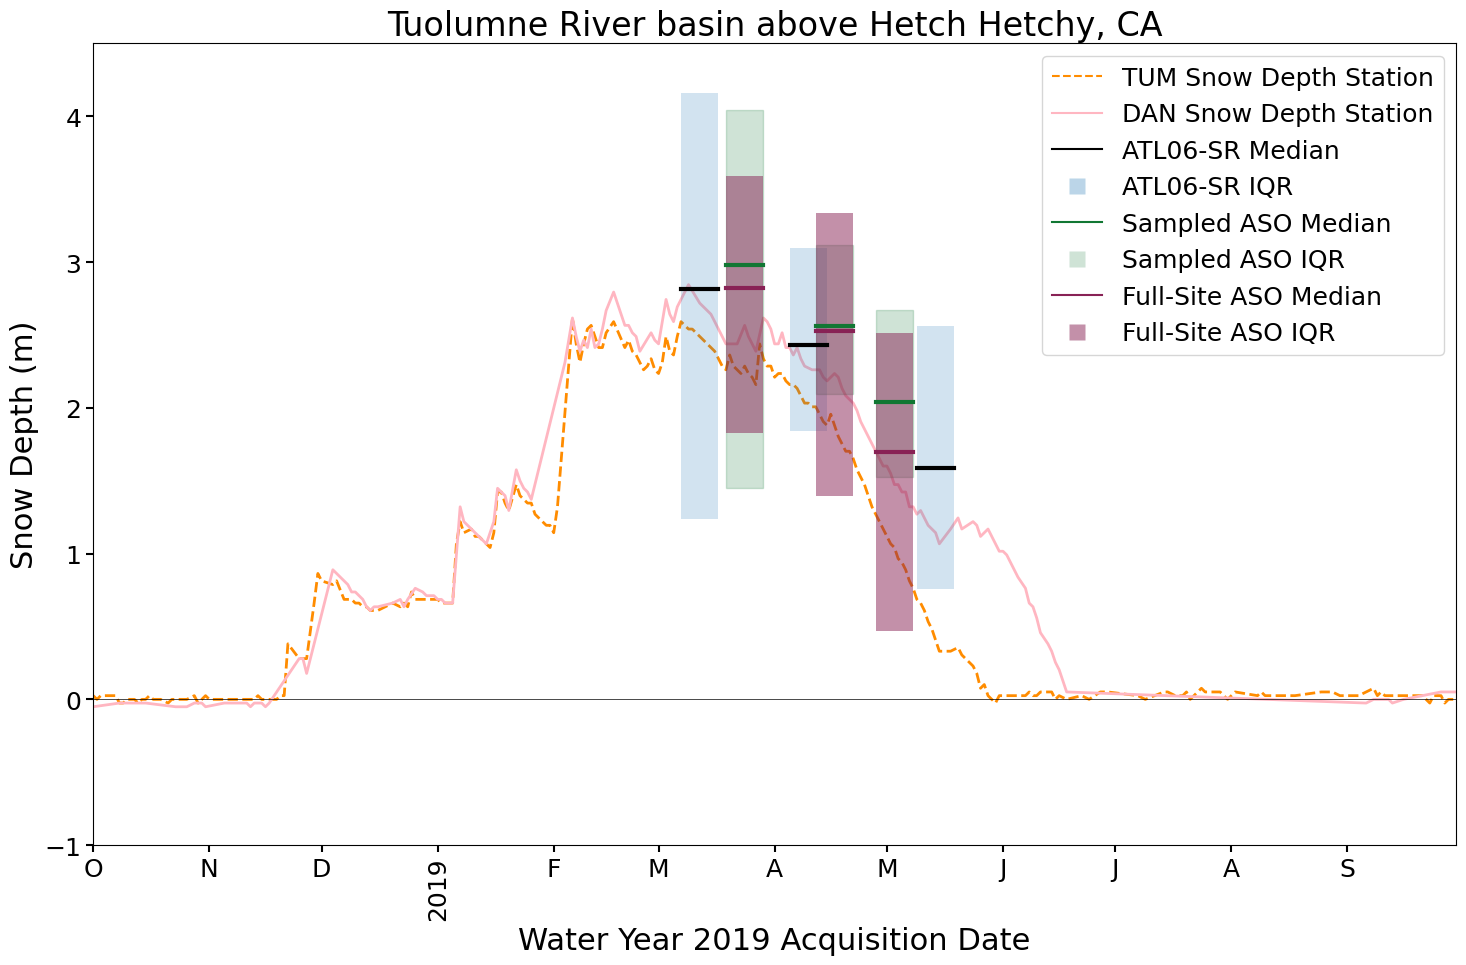

In [23]:
# Figure 5 of manuscript
from datetime import datetime
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='#117733'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='#882255'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None')
          ]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station','ATL06-SR Median', 'ATL06-SR IQR', 'Sampled ASO Median', 'Sampled ASO IQR', 'Full-Site ASO Median', 'Full-Site ASO IQR',]

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus_bicubic', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4.5), name = 'boxplots_asotracks_basin_2019_paper')

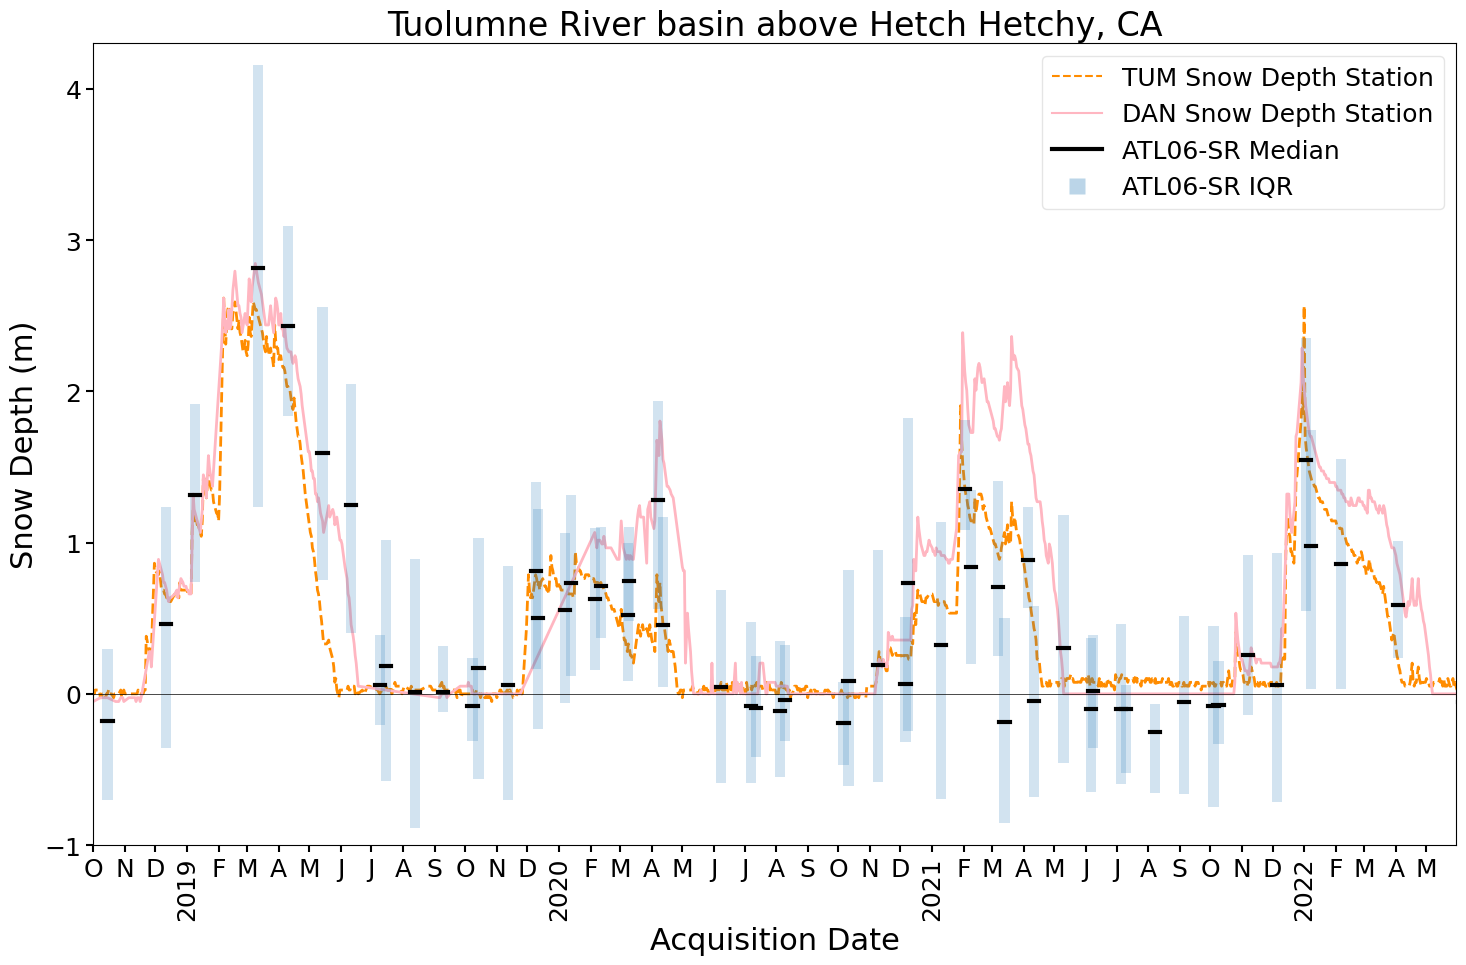

In [26]:
# Figure 3 of manuscript:

boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          ]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station', 'ATL06-SR Median', 'ATL06-SR IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus_bicubic', rasterstats=False, clim=(-1,4.3), name = 'boxplots_atl06sr_telemetry_paper_dates')

## Plot data separately, for presentations:
(Such as Master's Defense and IGARSS 2023)

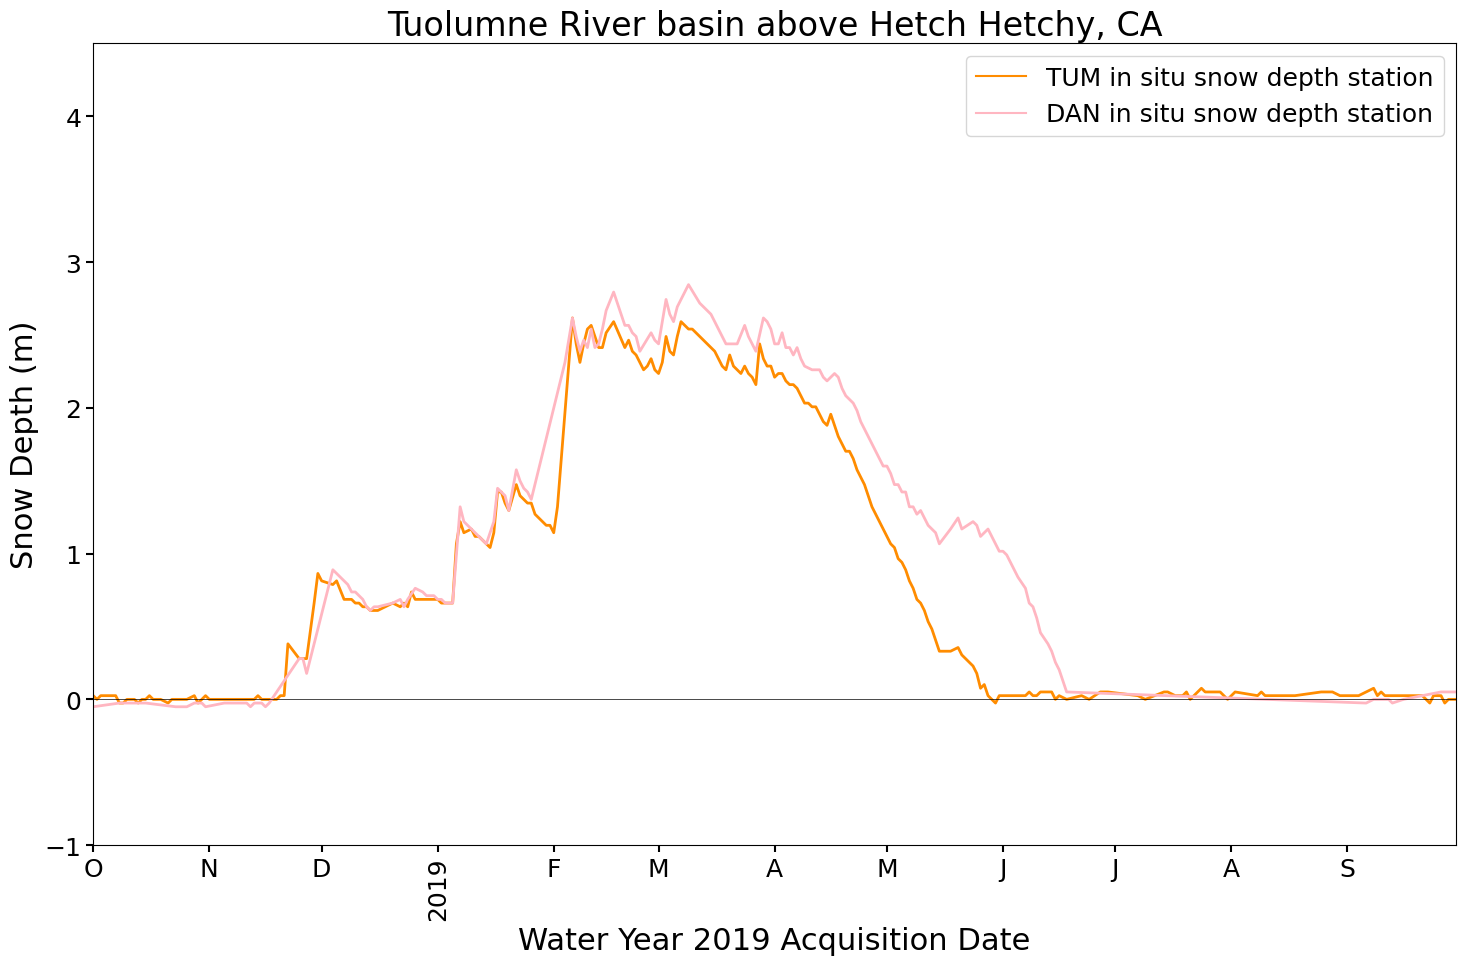

In [25]:
boxplot_color = (31/255,119/255, 180/255, 0.6)

custom = [Line2D([], [], linestyle='-', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          ]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['TUM in situ snow depth station', 'DAN in situ snow depth station']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(rasterstats=False, clim=(-1,4.5), name = 'boxplots_telemetry_2019_pres')

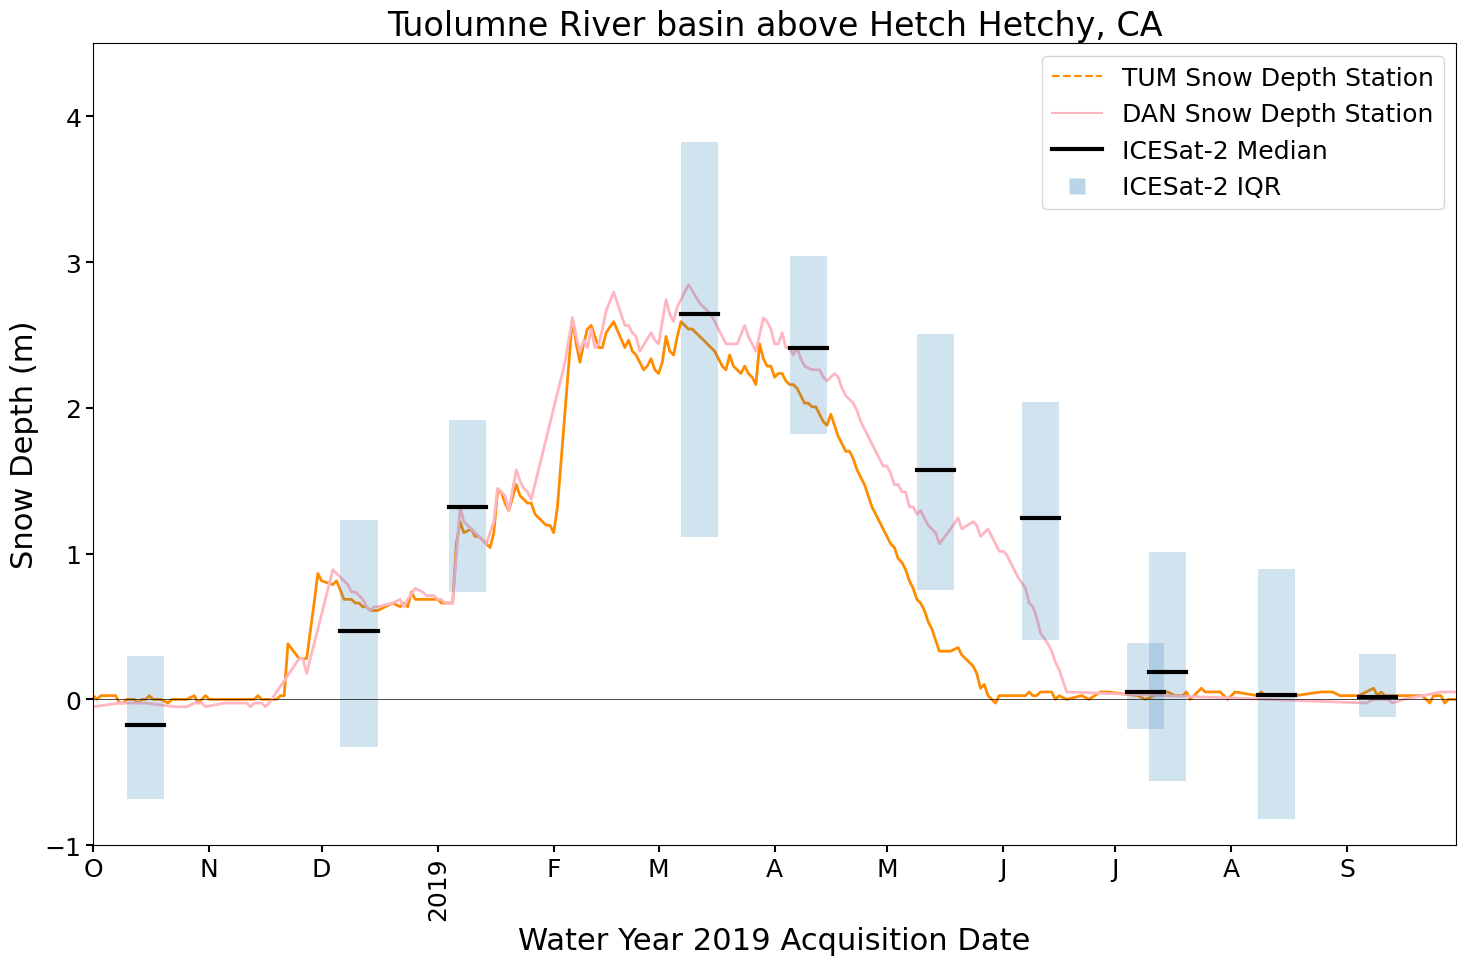

In [26]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          ]
    

custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station', 'ICESat-2 Median', 'ICESat-2 IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf_inner, col='diff_plus_bicubic', rasterstats=False, clim=(-1,4.5), name = 'boxplots_atl06sr_telemetry_2019_pres')

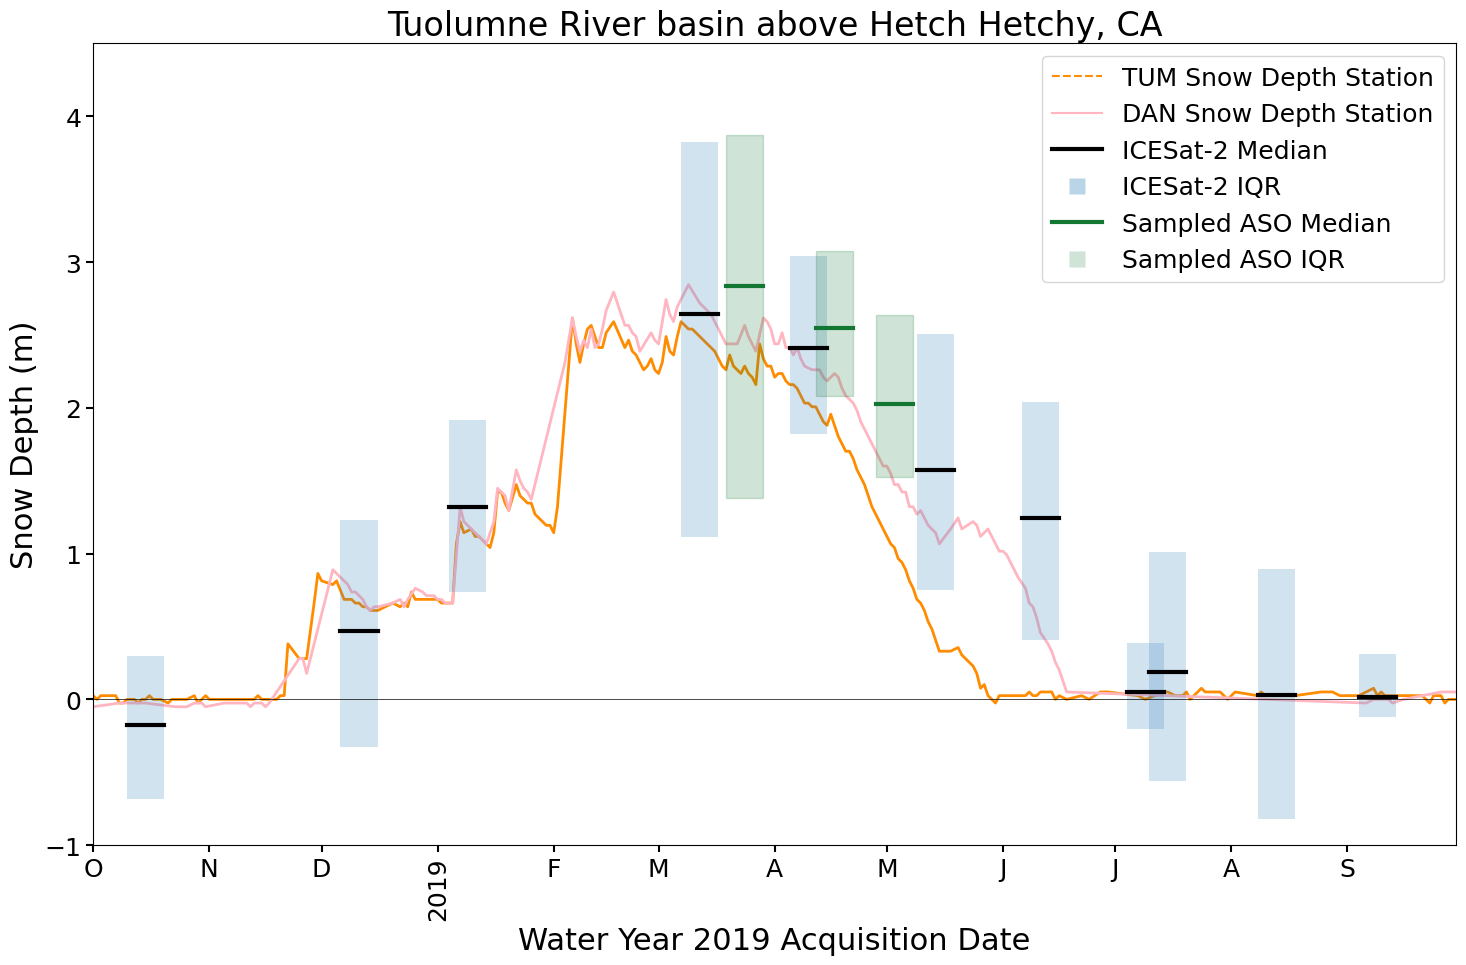

In [55]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          ]
    

custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station', 'ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ASO Median', 'Sampled ASO IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf_inner, col='diff_plus_bicubic', col_aso='ASO_snowon', rasterstats=False, clim=(-1,4.5), name = 'boxplots_als_atl06sr_telemetry_2019_pres')

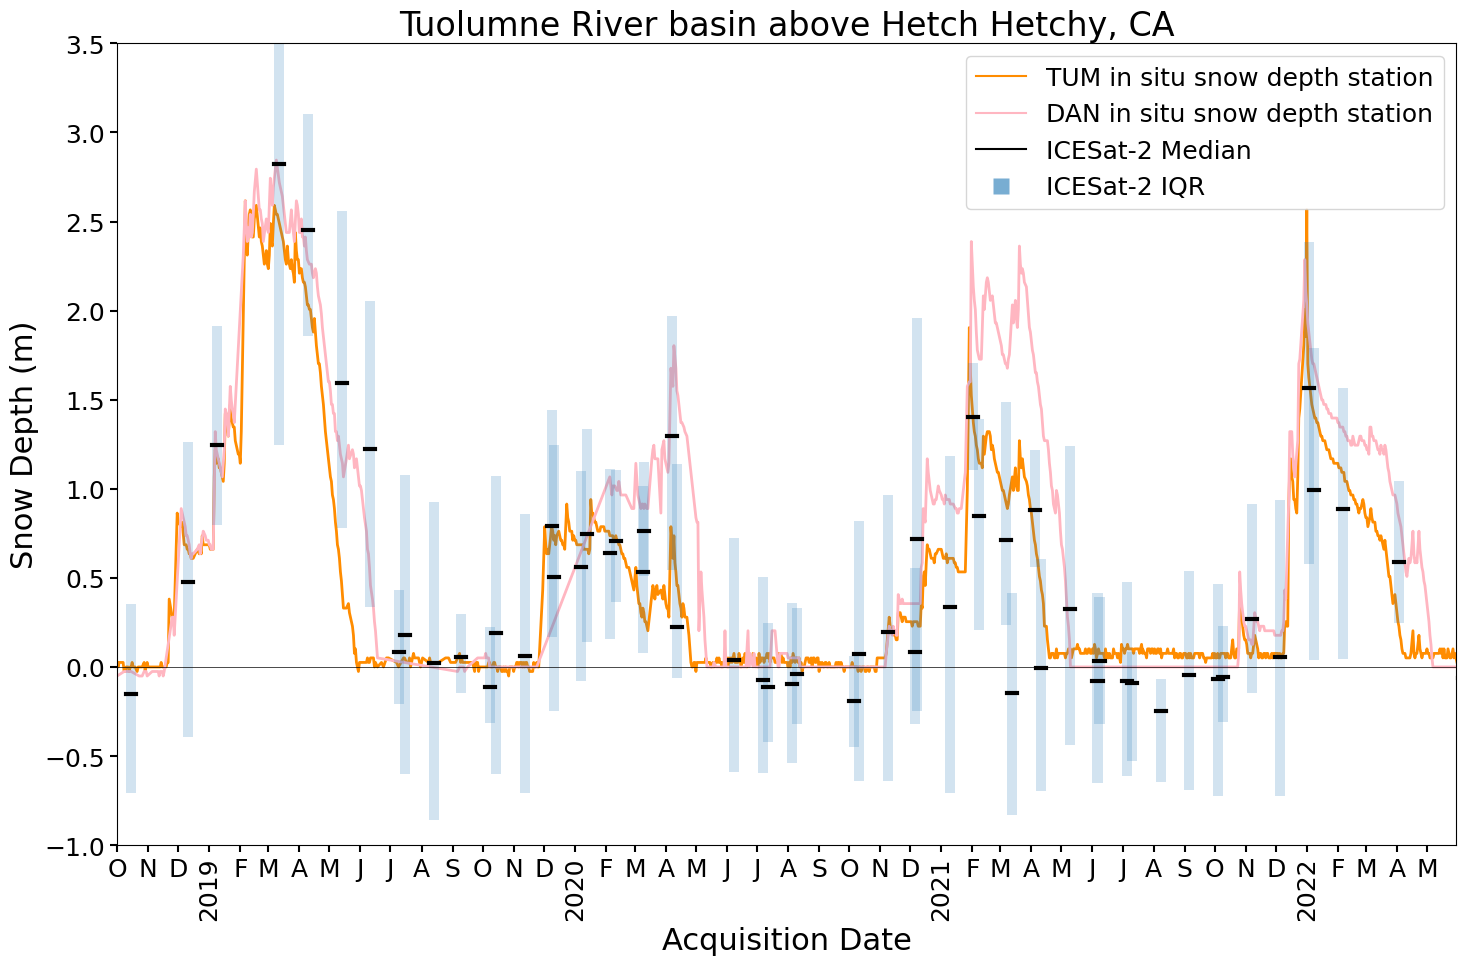

In [24]:
boxplot_color = (31/255,119/255, 180/255, 0.6)

custom = [Line2D([], [], linestyle='-', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['TUM in situ snow depth station', 'DAN in situ snow depth station','ICESat-2 Median', 'ICESat-2 IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,3.5), name = 'boxplots_asotracks_basin_proposal')

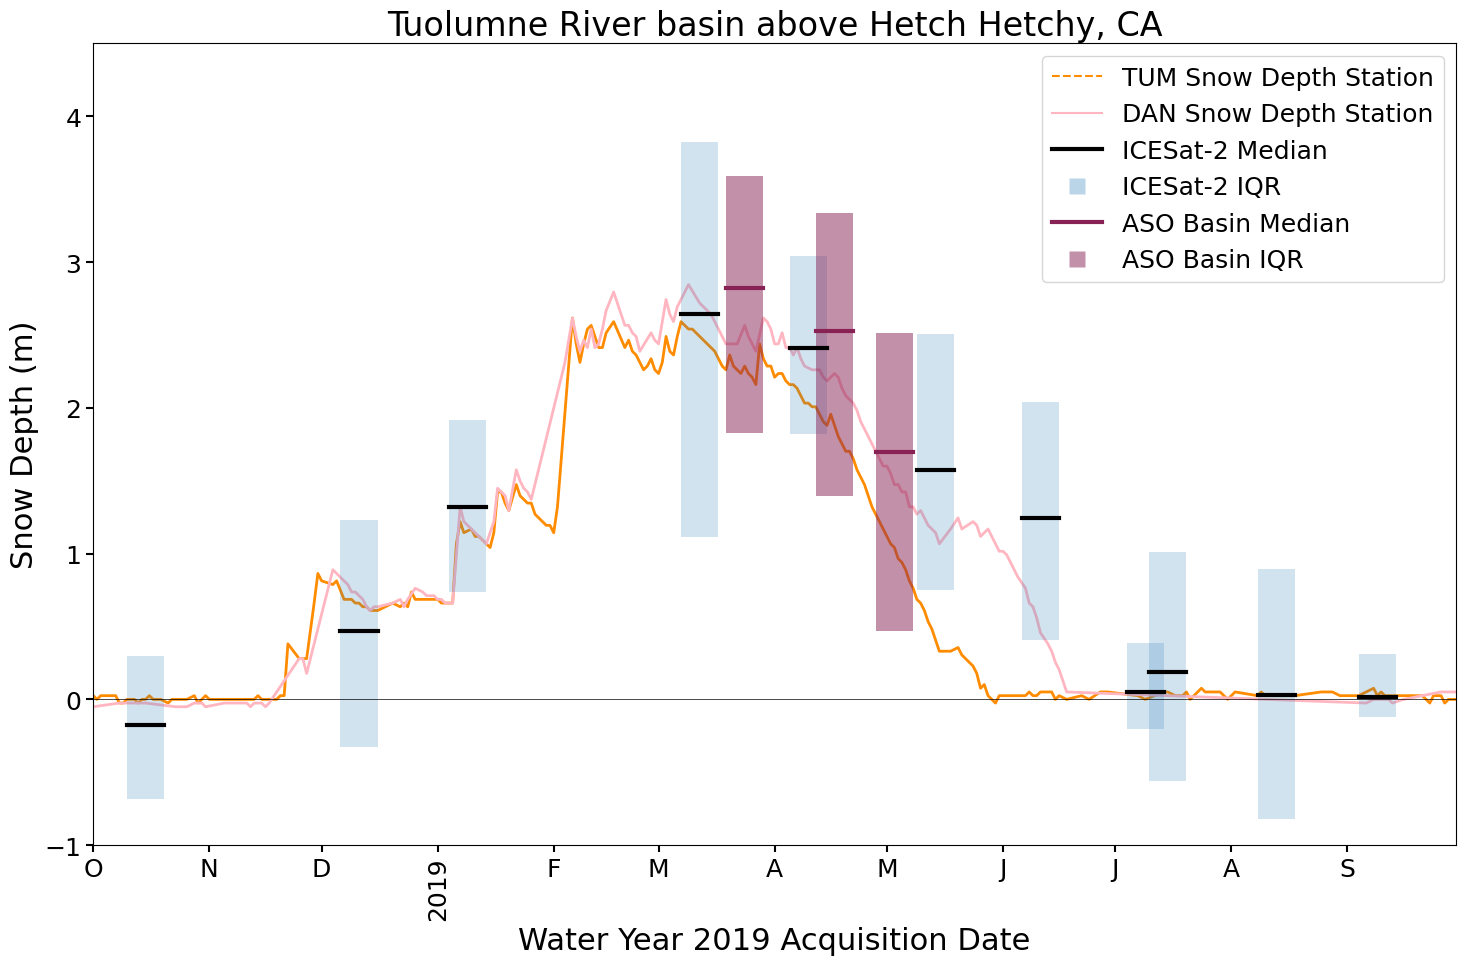

In [57]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          # Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          # Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None')]
    

custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station', 'ICESat-2 Median', 'ICESat-2 IQR', 'ASO Basin Median', 'ASO Basin IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf_inner, col='diff_plus_bicubic', rasterstats=True, clim=(-1,4.5), name = 'boxplots_als_atl06sr_telemetry_2019_pres')

# Old Code

In [22]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),]
    

custom_labels = ['TUM Snow Depth Station', 'DAN Snow Depth Station']

# Function adapted from David Shean by Hannah Besso
# No transparency

def boxplot_date_aso_all(df=None, col=None, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    if df != None:
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = bp_alpha/bp_alpha.max()
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(15,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, linestyle='--', label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    if df != None:
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
                       medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
                    medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
                        medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
    if df != None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            patch.set_edgecolor('None')
            #patch.set_facecolor('#3BA795')
            patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('#117733')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('#882255')
            patch.set_edgecolor('none')
            patch.set_alpha(0.5)
            #patch.set_hatch('o')
    ax.legend(custom, custom_labels, loc='upper right', fontsize=18) #, fontsize=10
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    # legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    # legend1.set_alpha(1)
    # if rasterstats:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    # elif col_aso != None:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    # else:
    #     legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    # ax.add_artist(legend1)
    # ax.add_artist(legend2)
    
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if df != None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            #patch.set_alpha(alpha)
            patch.set_edgecolor('None')
            patch.set_linewidth(0)
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            #patch.set_alpha(alpha)
            patch.set_color('k')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
    #     patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    # if col_aso != None:
    #     # for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
    #     #     patch.set_alpha(alpha)    
    #     for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
    #         #patch.set_alpha(alpha)
    #         patch.set_color('k')  # or deeppink
    #     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    #     # for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
    #     #     patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=20)
    ax.set_xlabel('Acquisition Date', fontsize=20)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title('Tuolumne Basin', fontsize=24)
    #ax.set_title(title) 
     
    # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]
    
    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))
    
    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=2, which='major')
    
#     years = mdates.MonthLocator(bymonth=(4, 10))
#     ax.format_xdata = mdates.DateFormatter('%b %d %Y')
#     years_fmt = mdates.DateFormatter('%b %d \n%Y')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    plt.tight_layout()
    #plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [51]:


# # Function adapted from David Shean by Hannah Besso
# # No transparency

# def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
#                          title='Tuolumne Basin', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
#     # ATL06 stats
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     # ASO Snow-On Stats tracks
#     if col_aso != None:
#         bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
#         bp_stats_list2 = [i[0] for i in bp_stats2.values]
#         bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
#         bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
#         pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
#     # ASO Snow-On Stats whole region
#     if rasterstats:
        
#         bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
#     f, ax = plt.subplots(figsize=(15,10))
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', linestyle='--', lw=2, label='Tuolumne Meadows')
#     snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
#     # Plot ATL06 data
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
#                    medianprops={'lw':3},widths=10, patch_artist=True)
#     # Plot ASO snow on data
#     if col_aso != None:
#         bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
#                     whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
#                     medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
#     if rasterstats:
#         bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
#                         whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
#                         medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_edgecolor('None')
#         #patch.set_facecolor('#3BA795')
#         patch.set_linewidth(0)
#     if col_aso != None:
#         for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
#             patch.set_color('#117733')
#     if rasterstats:
#         for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
#             patch.set_facecolor('#882255')
#             patch.set_edgecolor('none')
#             patch.set_alpha(0.5)
#             #patch.set_hatch('o')
#     ax.legend(custom, custom_labels, loc='upper right', fontsize=18) #, fontsize=10
    
#     # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
#     # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
#     # legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
#     # legend1.set_alpha(1)
#     # if rasterstats:
#     #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
#     # elif col_aso != None:
#     #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
#     # else:
#     #     legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
#     # ax.add_artist(legend1)
#     # ax.add_artist(legend2)
    
    
#     #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         #patch.set_alpha(alpha)
#         patch.set_edgecolor('None')
#         patch.set_linewidth(0)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         #patch.set_alpha(alpha)
#         patch.set_color('k')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#     #     patch.set_alpha(alpha)
        
#     #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     # if col_aso != None:
#     #     # for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
#     #     #     patch.set_alpha(alpha)    
#     #     for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
#     #         #patch.set_alpha(alpha)
#     #         patch.set_color('k')  # or deeppink
#     #     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     #     # for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
#     #     #     patch.set_alpha(alpha)   
    
#     ax.set_title(title, fontsize=24)
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Snow Depth (m)', fontsize=20)
#     ax.set_xlabel('Acquisition Date', fontsize=20)
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.set_title(title) 
   
#     # X AXIS LABELS     
#     months = mdates.MonthLocator()
#     month_fmt = mdates.DateFormatter('%b')
    
#     def m_fmt(x, pos=None):
#         return month_fmt(x)[0]
    
#     ax.xaxis.set_minor_locator(months) 
#     ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))
    
#     years = mdates.MonthLocator(bymonth=1)
#     ax.format_xdata = mdates.DateFormatter('%Y')
#     years_fmt = mdates.DateFormatter('%Y')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.tick_params('both', length=5, width=2, which='major')
    
# #     years = mdates.MonthLocator(bymonth=(4, 10))
# #     ax.format_xdata = mdates.DateFormatter('%b %d %Y')
# #     years_fmt = mdates.DateFormatter('%b %d \n%Y')
# #     ax.xaxis.set_major_locator(years)
# #     ax.xaxis.set_major_formatter(years_fmt)
# #     ax.tick_params('both', length=5, width=2, which='major')
    
#     for label in ax.get_xticklabels(which='major'): #
#         label.set(rotation=90, horizontalalignment='center')
    
#     plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

## Create Transparent Boxplots
Transparency is based on the number of points available for each date

In [17]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    # months = mdates.MonthLocator()
    # ax.format_xdata = mdates.DateFormatter('%m')
    # months_fmt = mdates.DateFormatter('%m')
    # ax.xaxis.set_major_locator(months)
    # ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}', dpi=500)

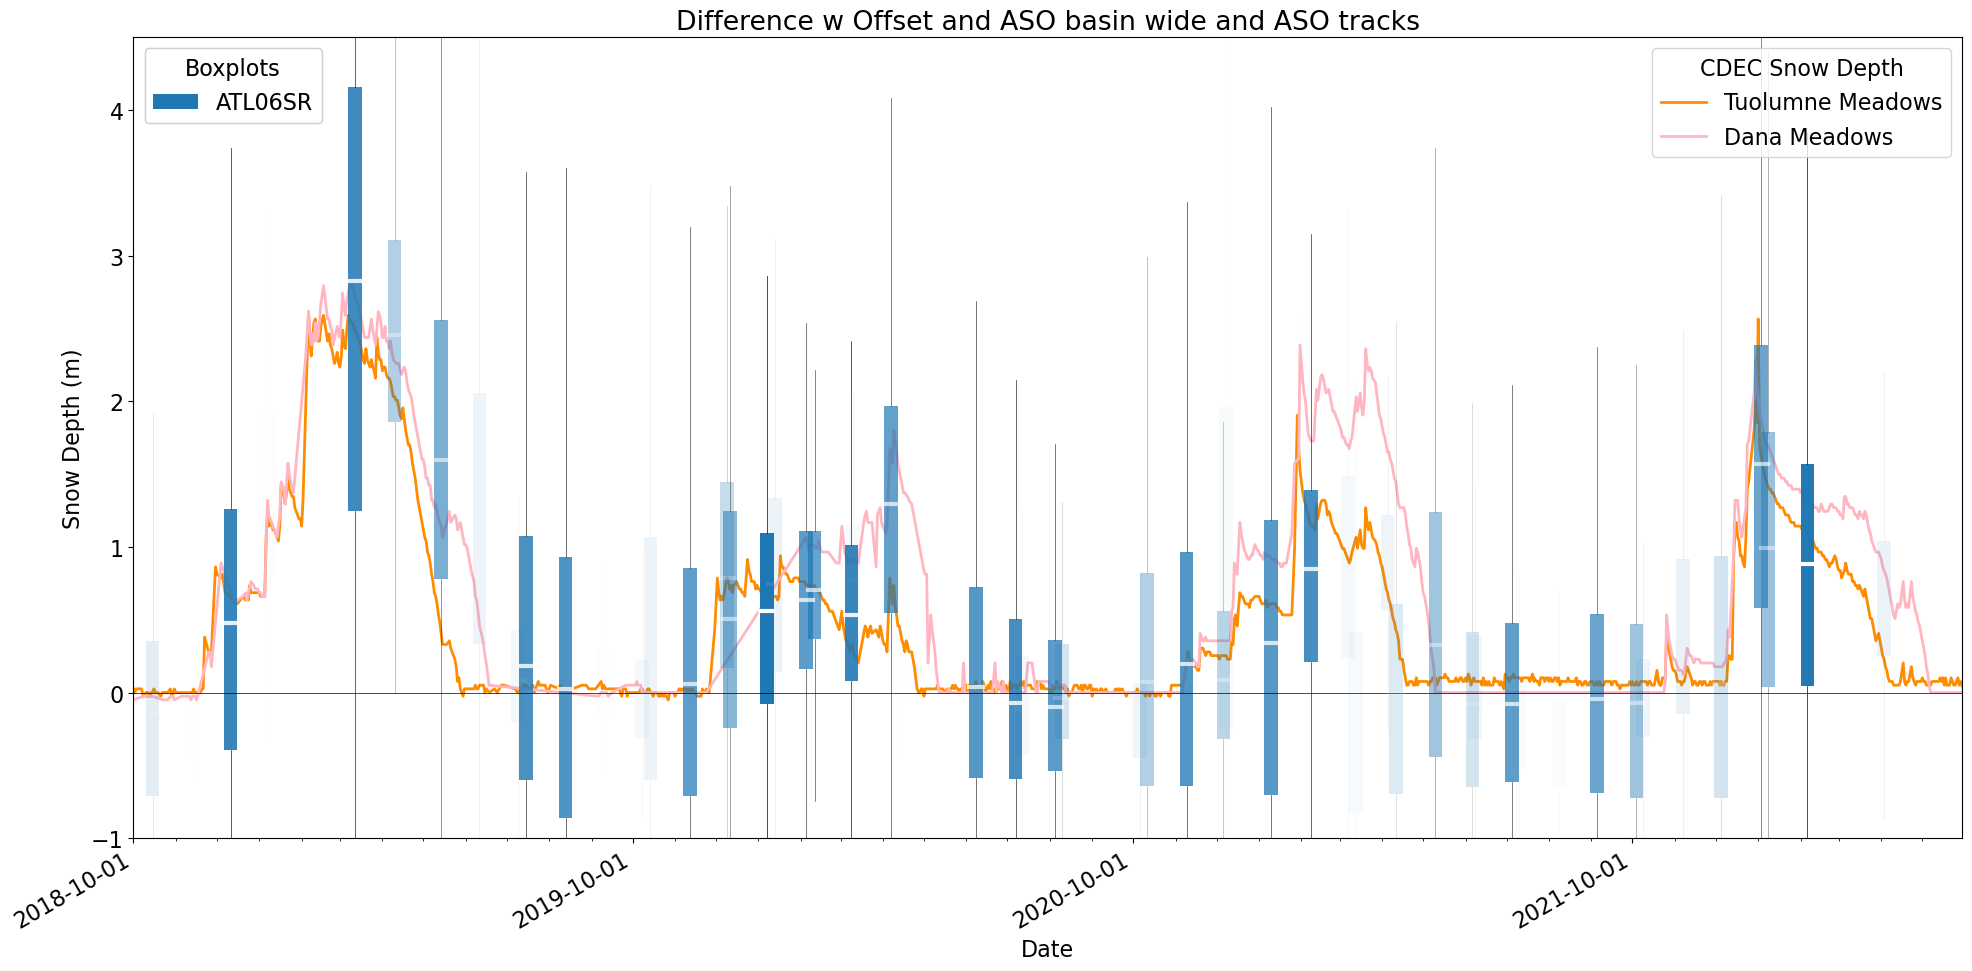

In [22]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,4.5), name = 'boxplots_atl06sr_transparent.jpeg')

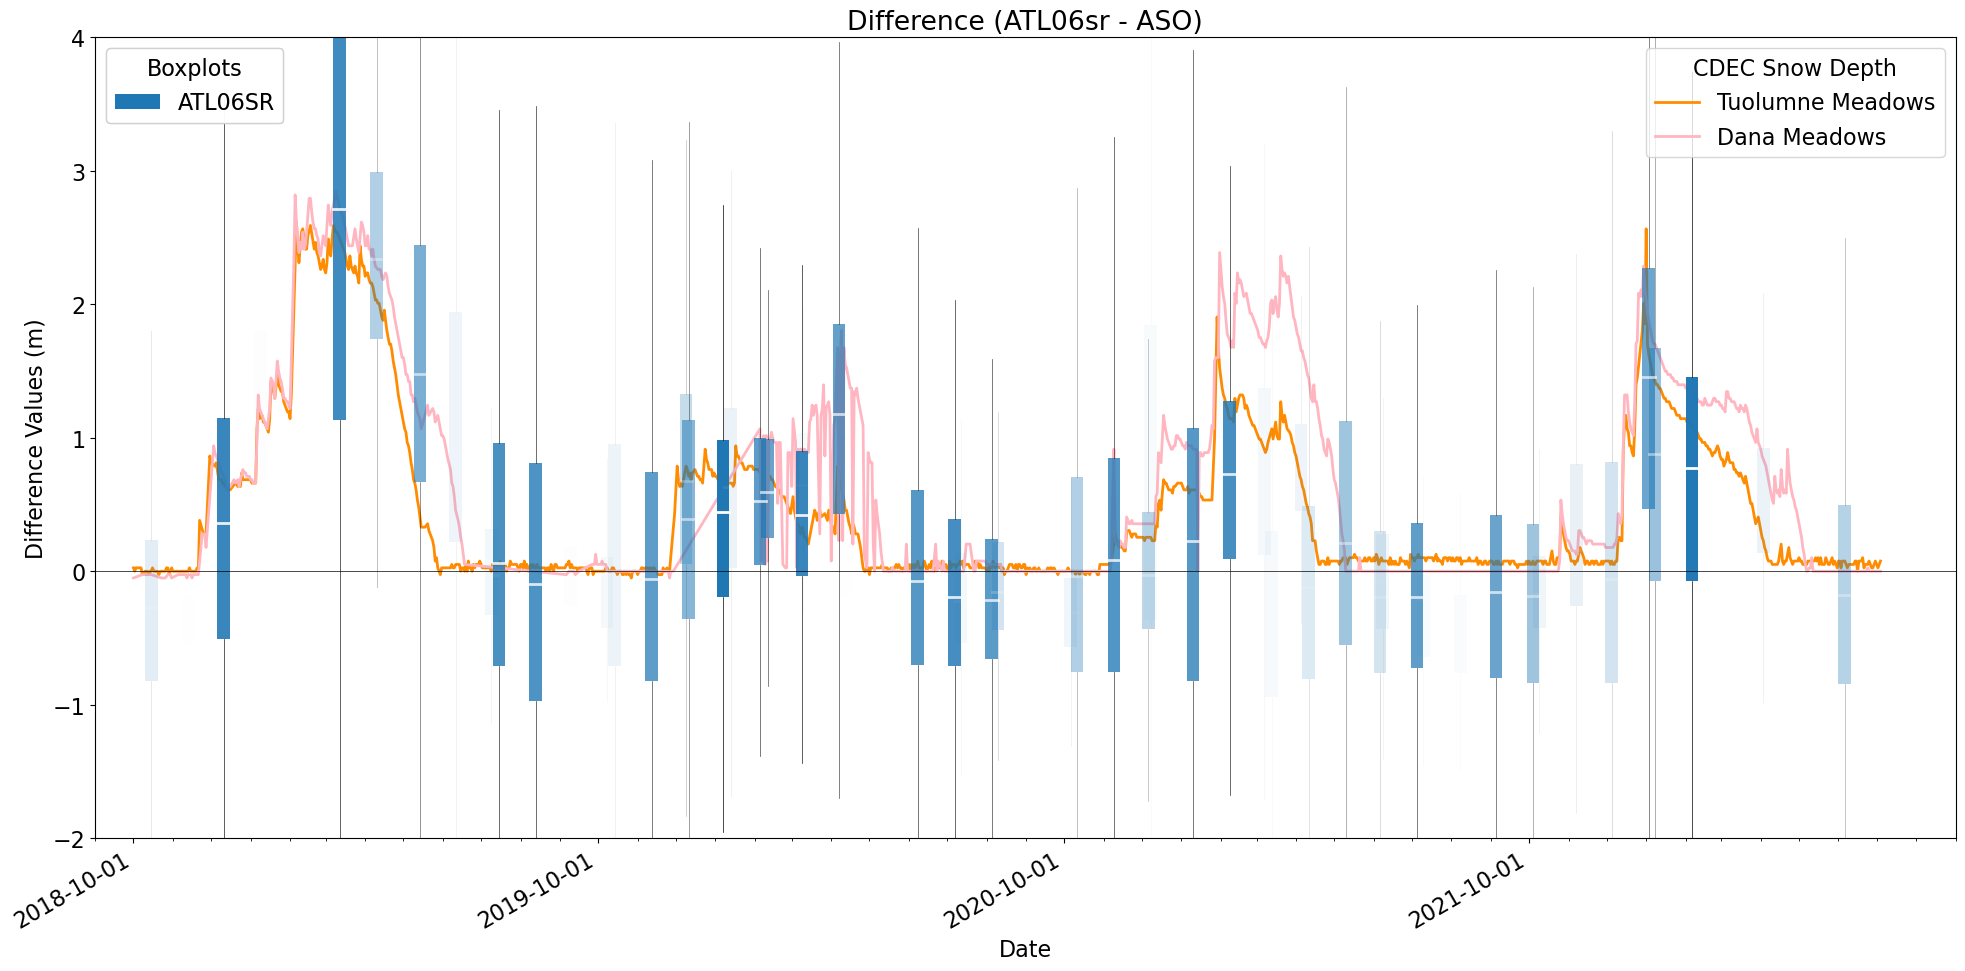

In [184]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,4), title='Difference (ATL06sr - ASO)', name = 'boxplots_difference.jpeg')

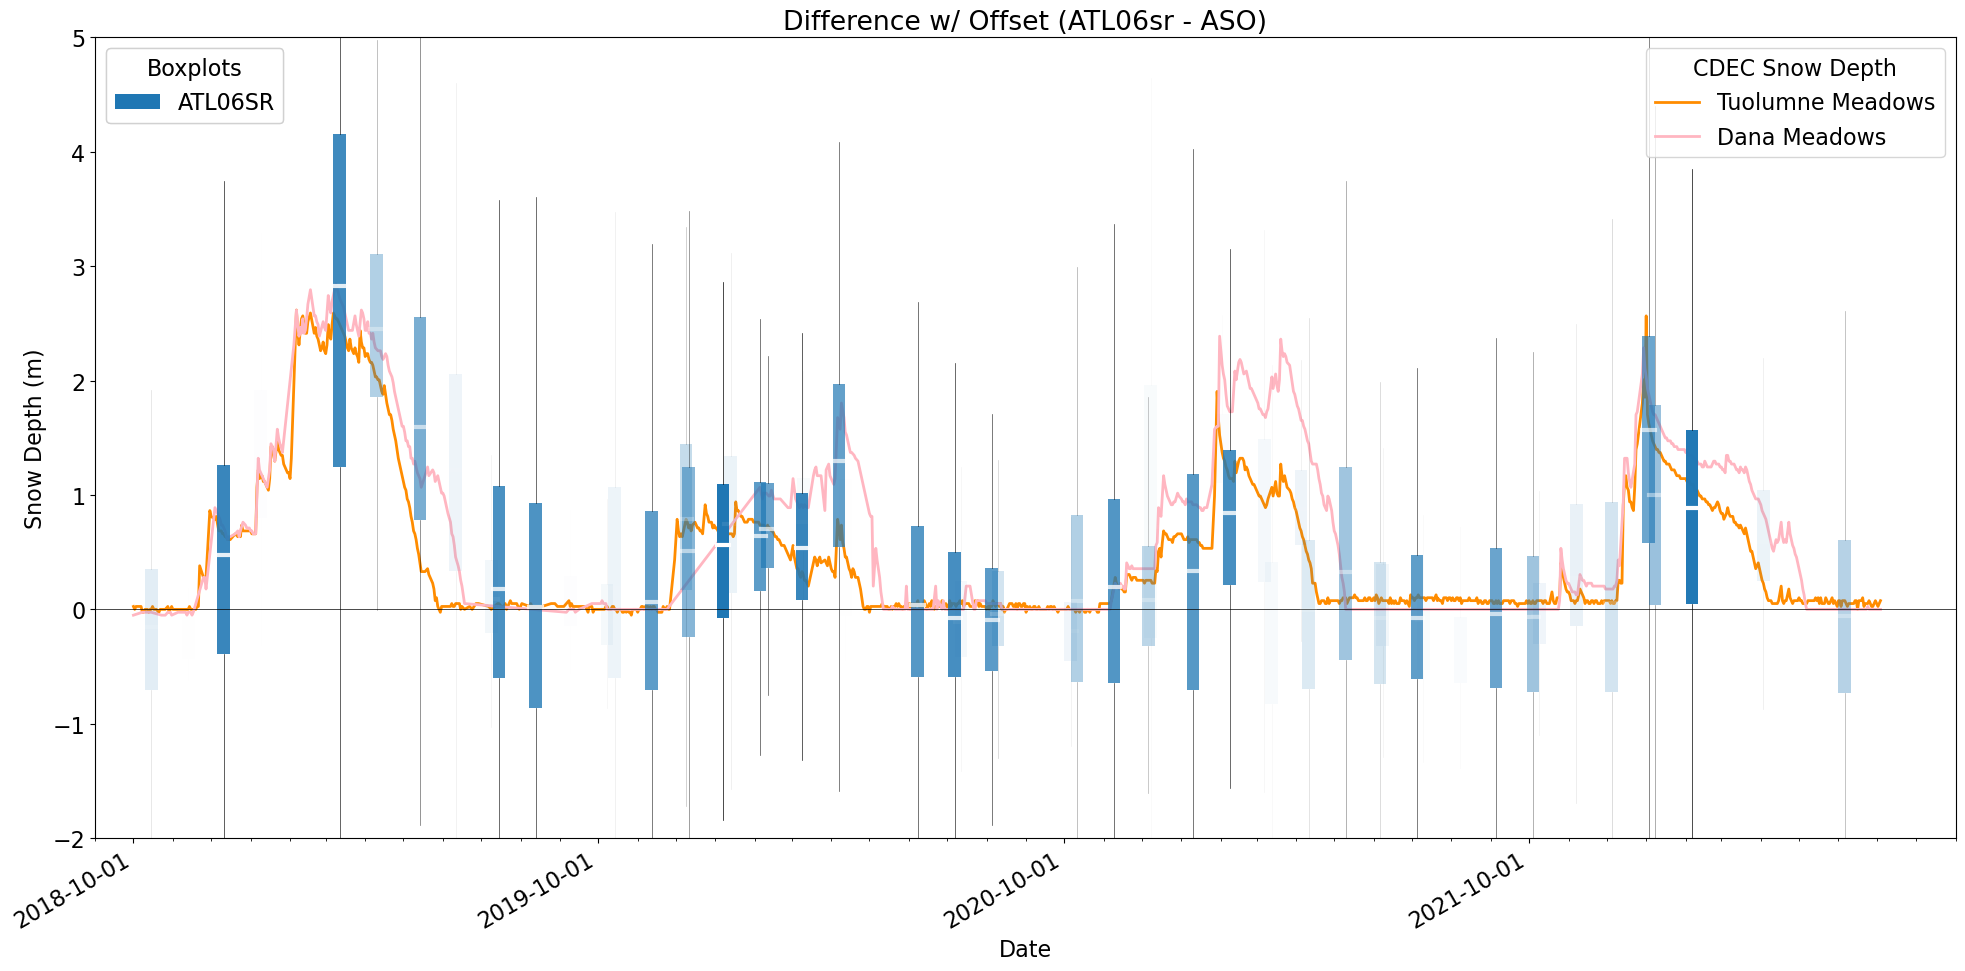

In [273]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', clim=(-2,5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus.jpeg')

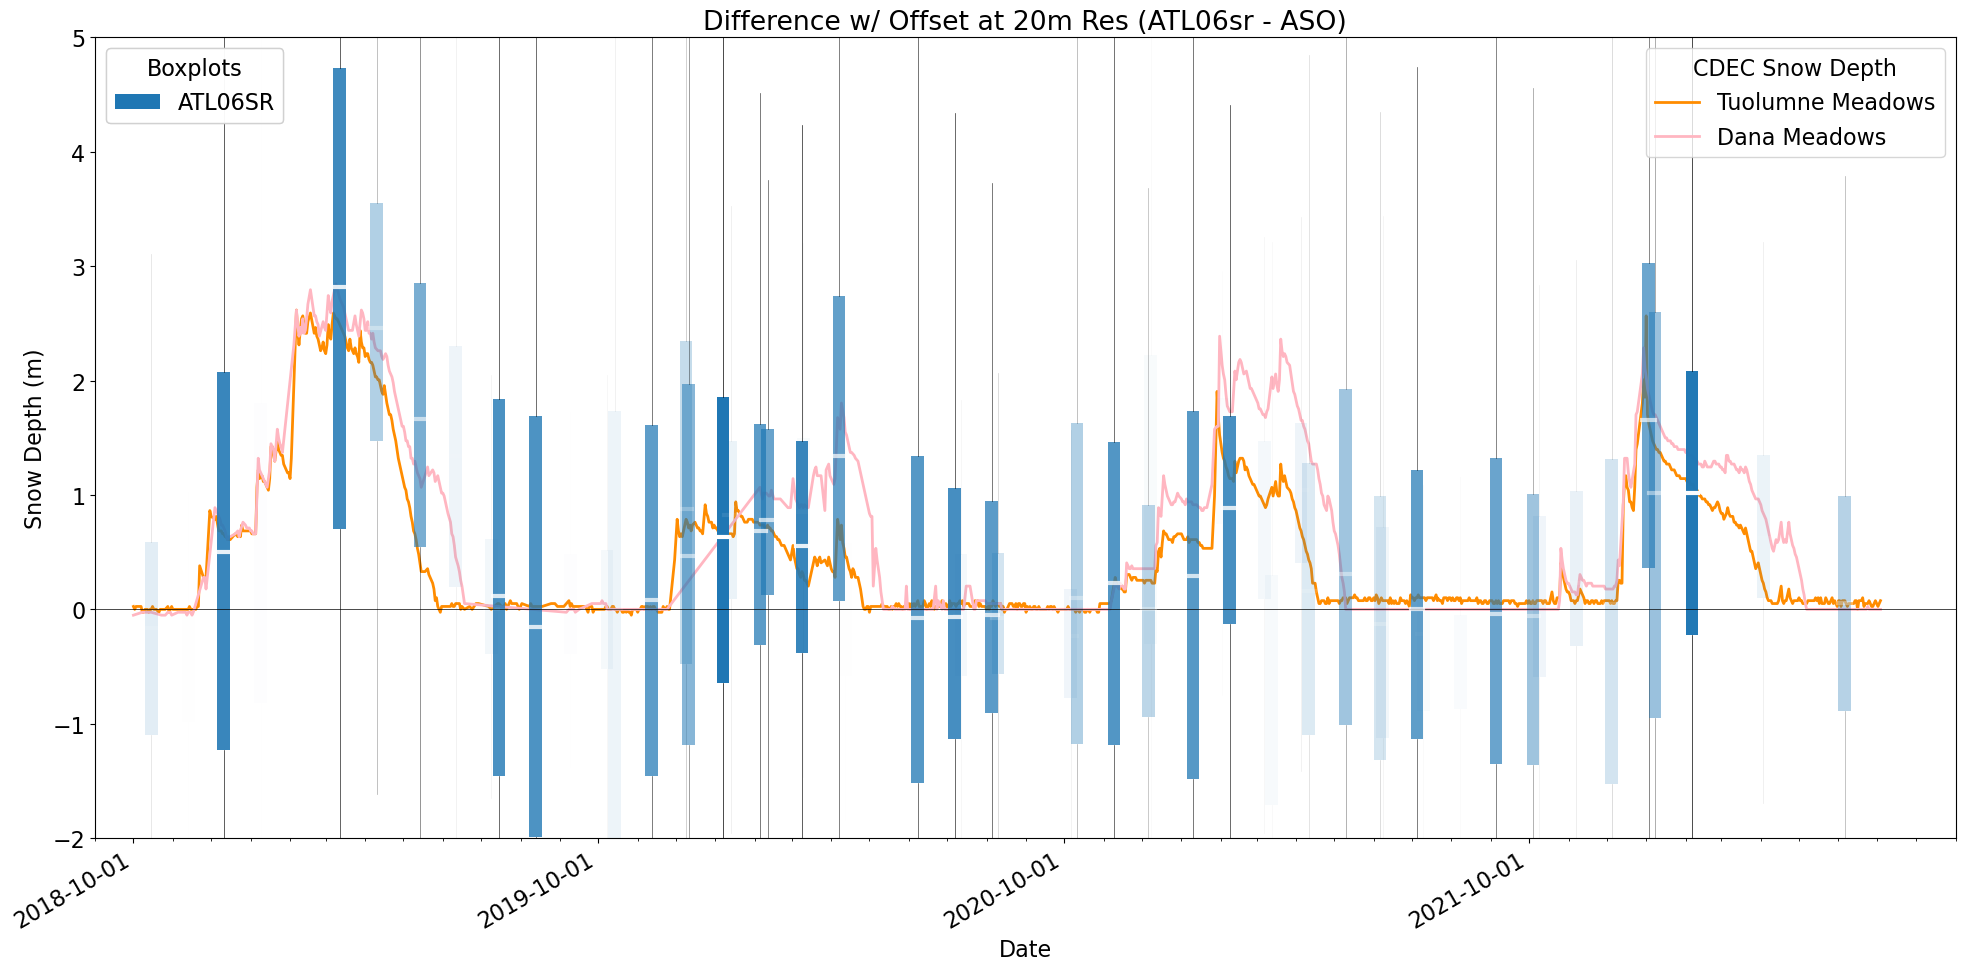

In [274]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-2,5), title = 'Difference w/ Offset at 20m Res (ATL06sr - ASO)', name = 'boxplots_diffplus_20m.jpeg')

### Transparent boxplots with ASO Snow-On Data

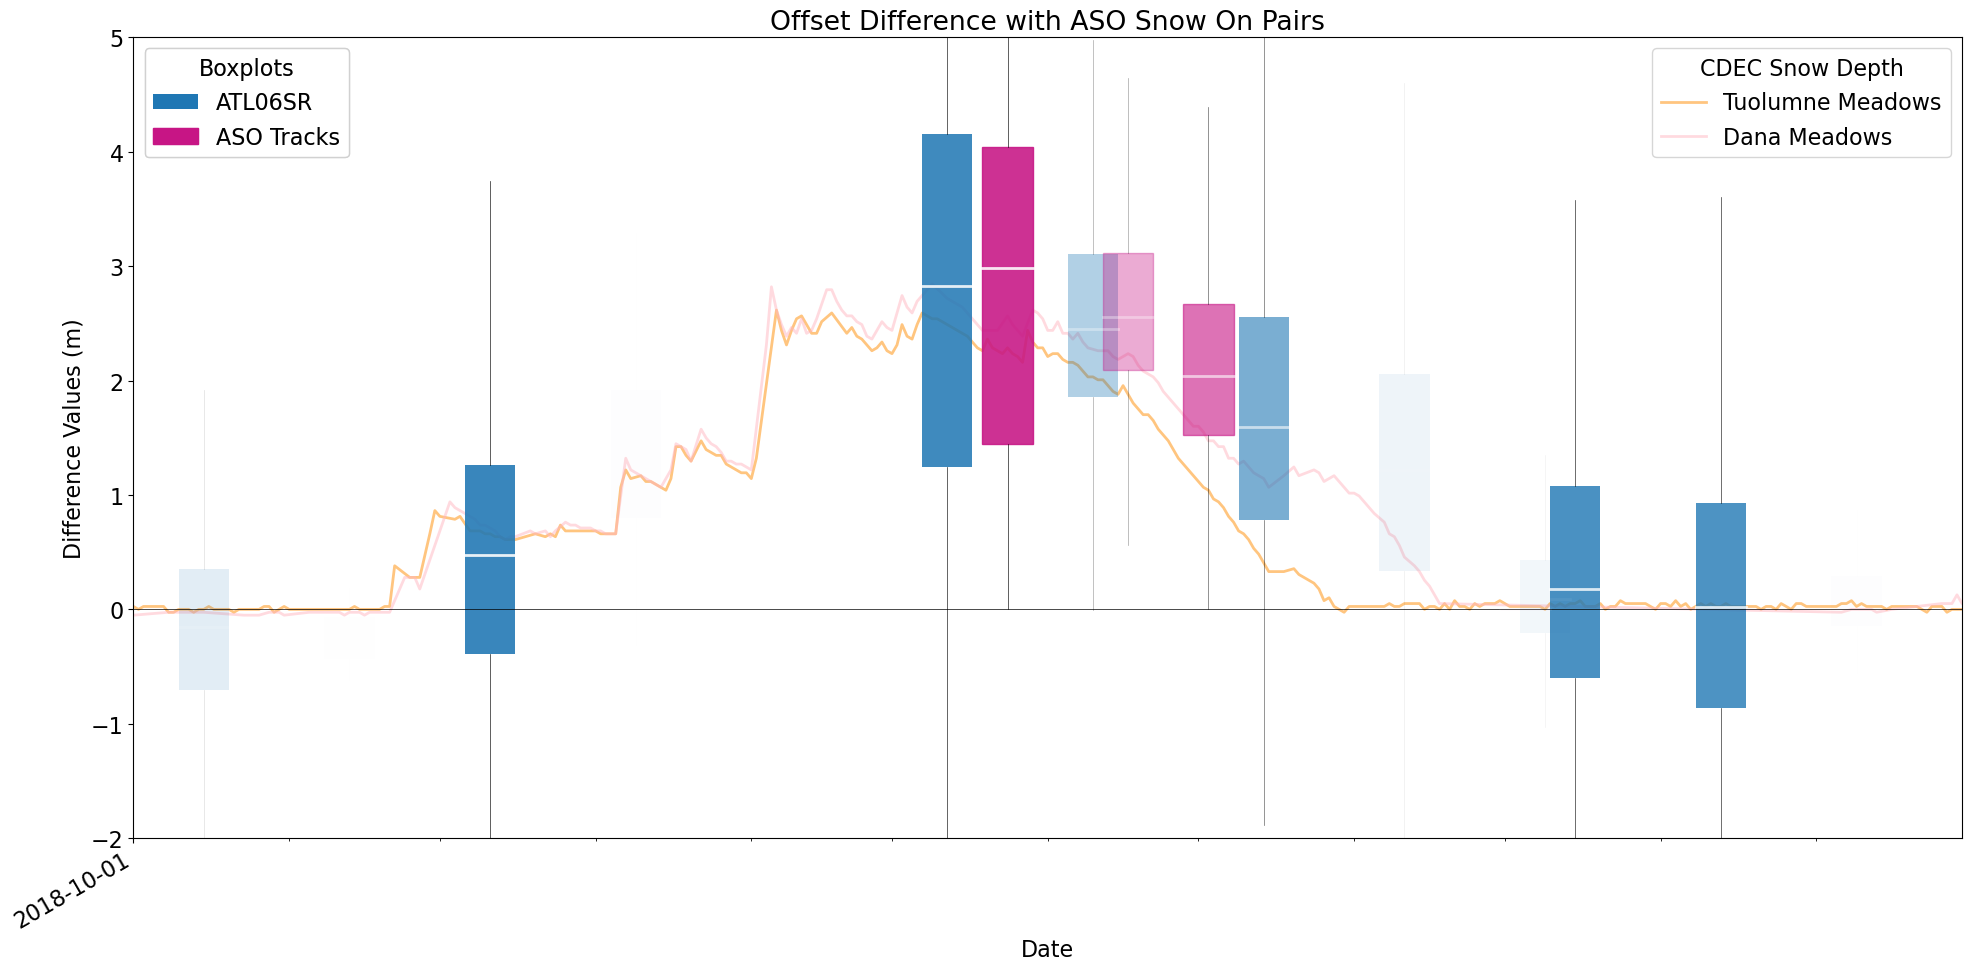

In [170]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Offset Difference with ASO Snow On Pairs', name = 'boxplots_asotracks_2019.jpeg')

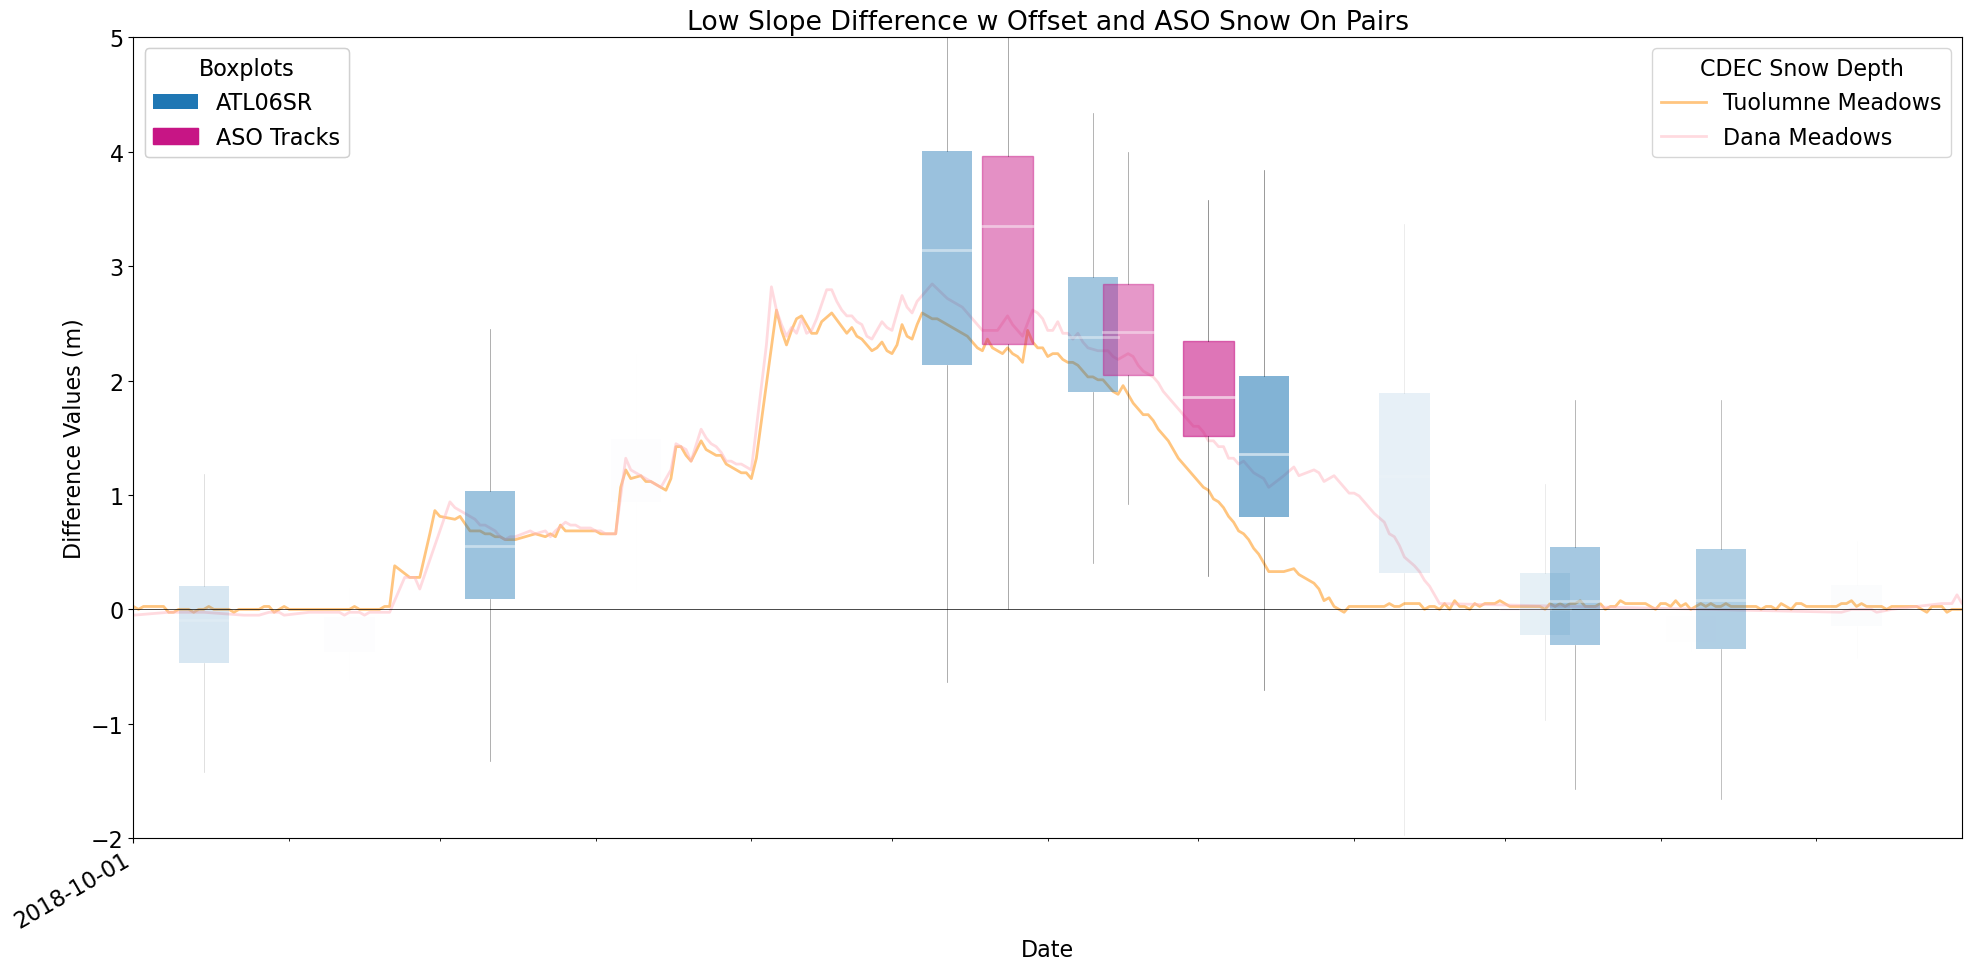

In [171]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_2019_lowslope.jpeg')

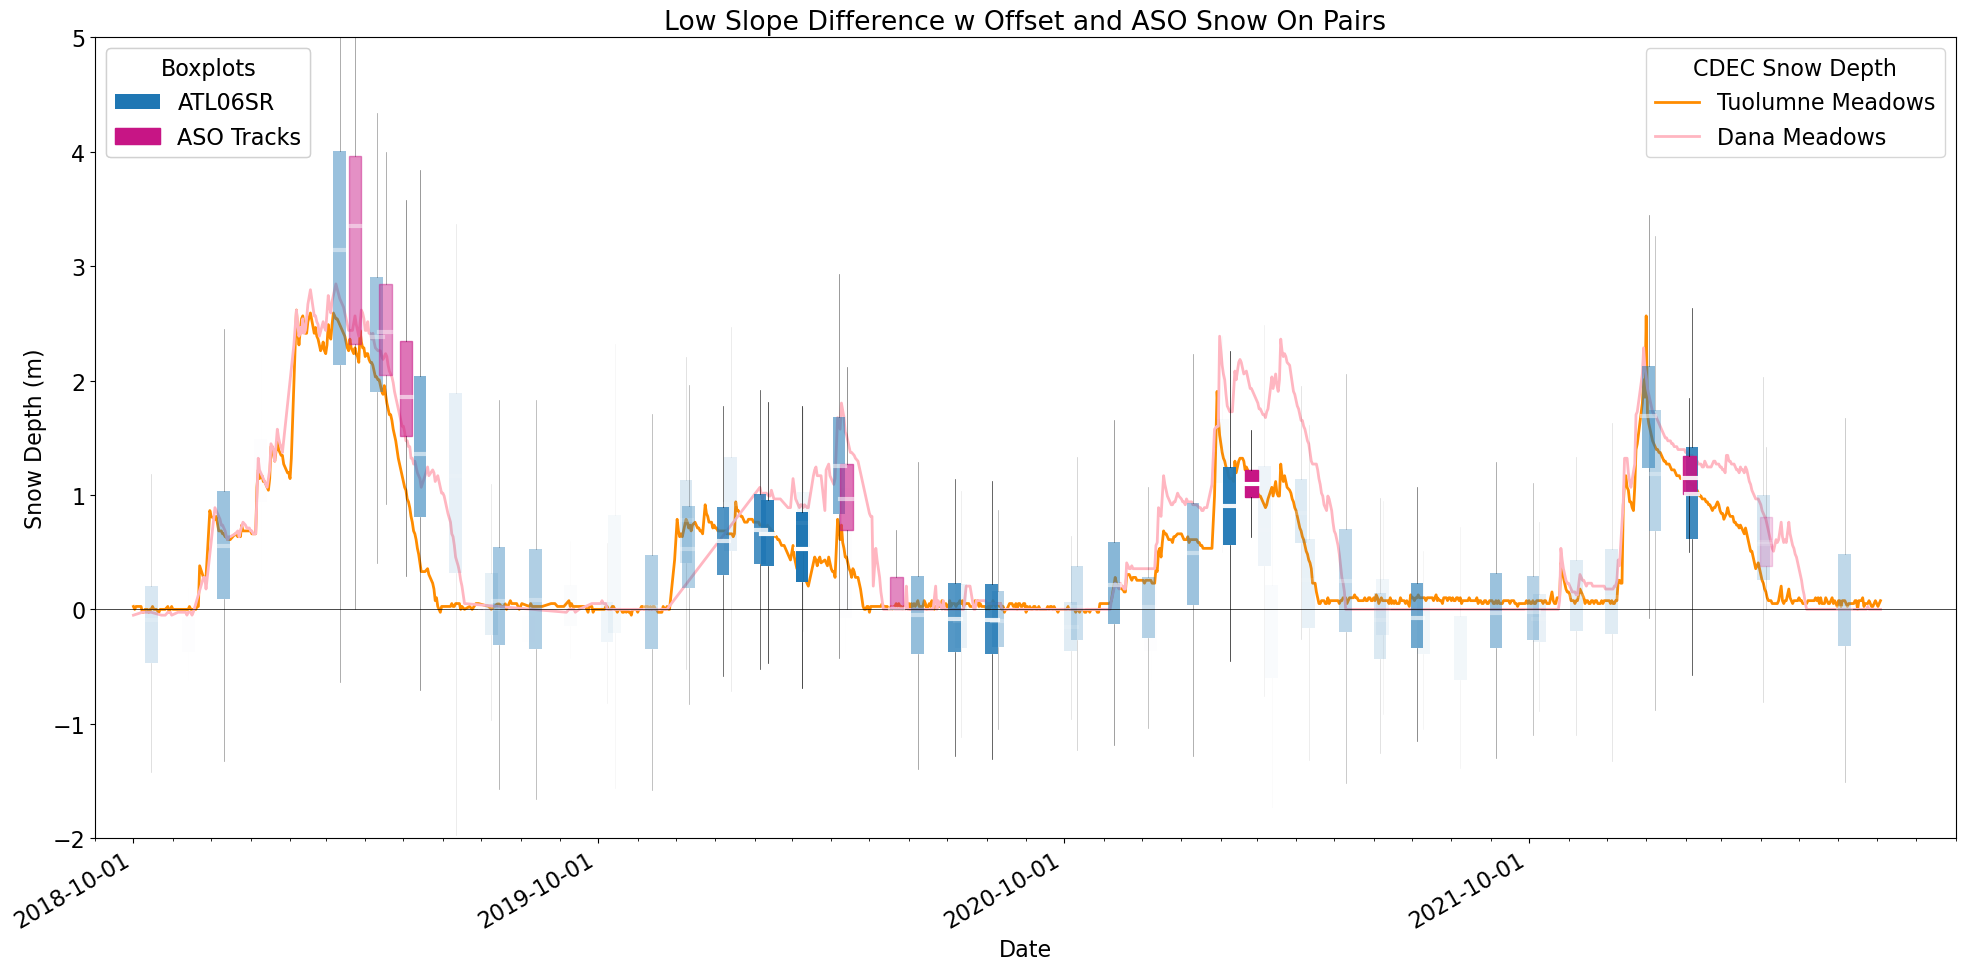

In [275]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_lowslope.jpeg')

## Transparent Boxplots with ASO Snow-On at ATL06SR and Entire Basin

#### Use rasterstats to make boxplots of ASO data for the Study area

### Look at all years of data:

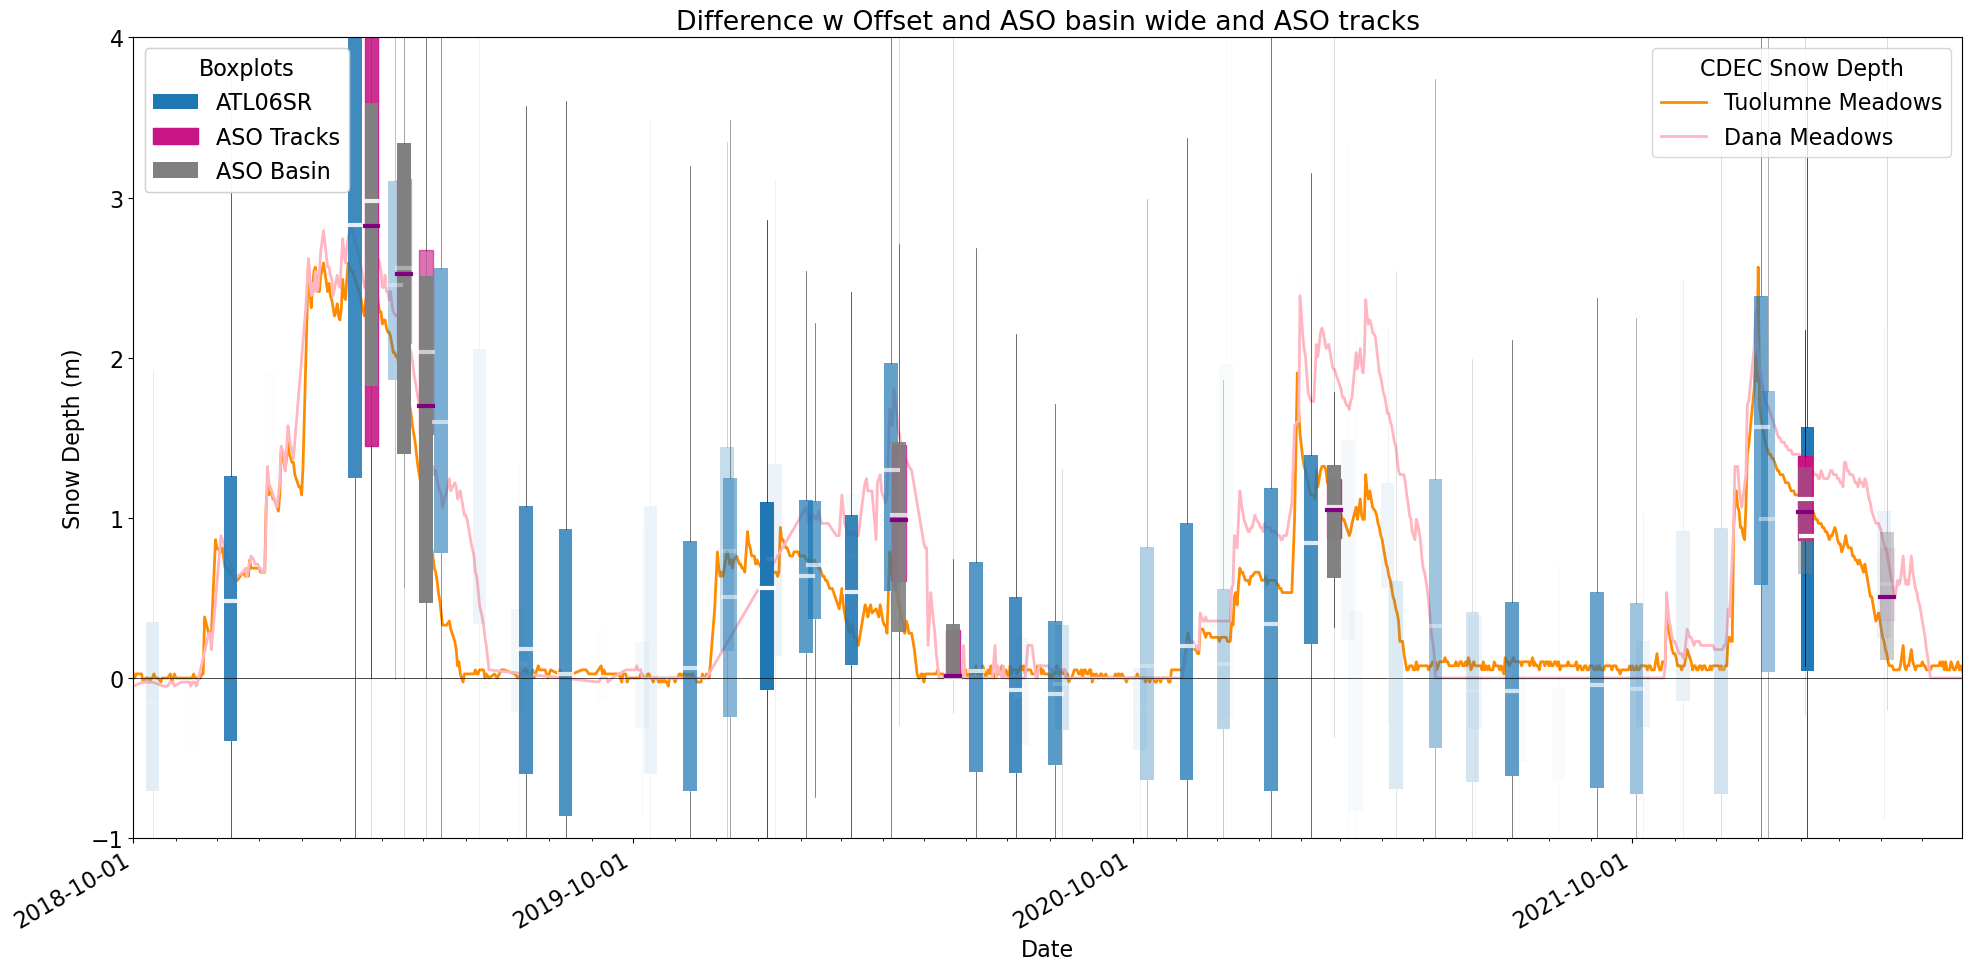

In [22]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4), name = 'boxplots_cdec_aso_allyears.jpeg')

## Look at only ATL06SR and ASO Temporal Pairs

In [153]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2019, 7, 9),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

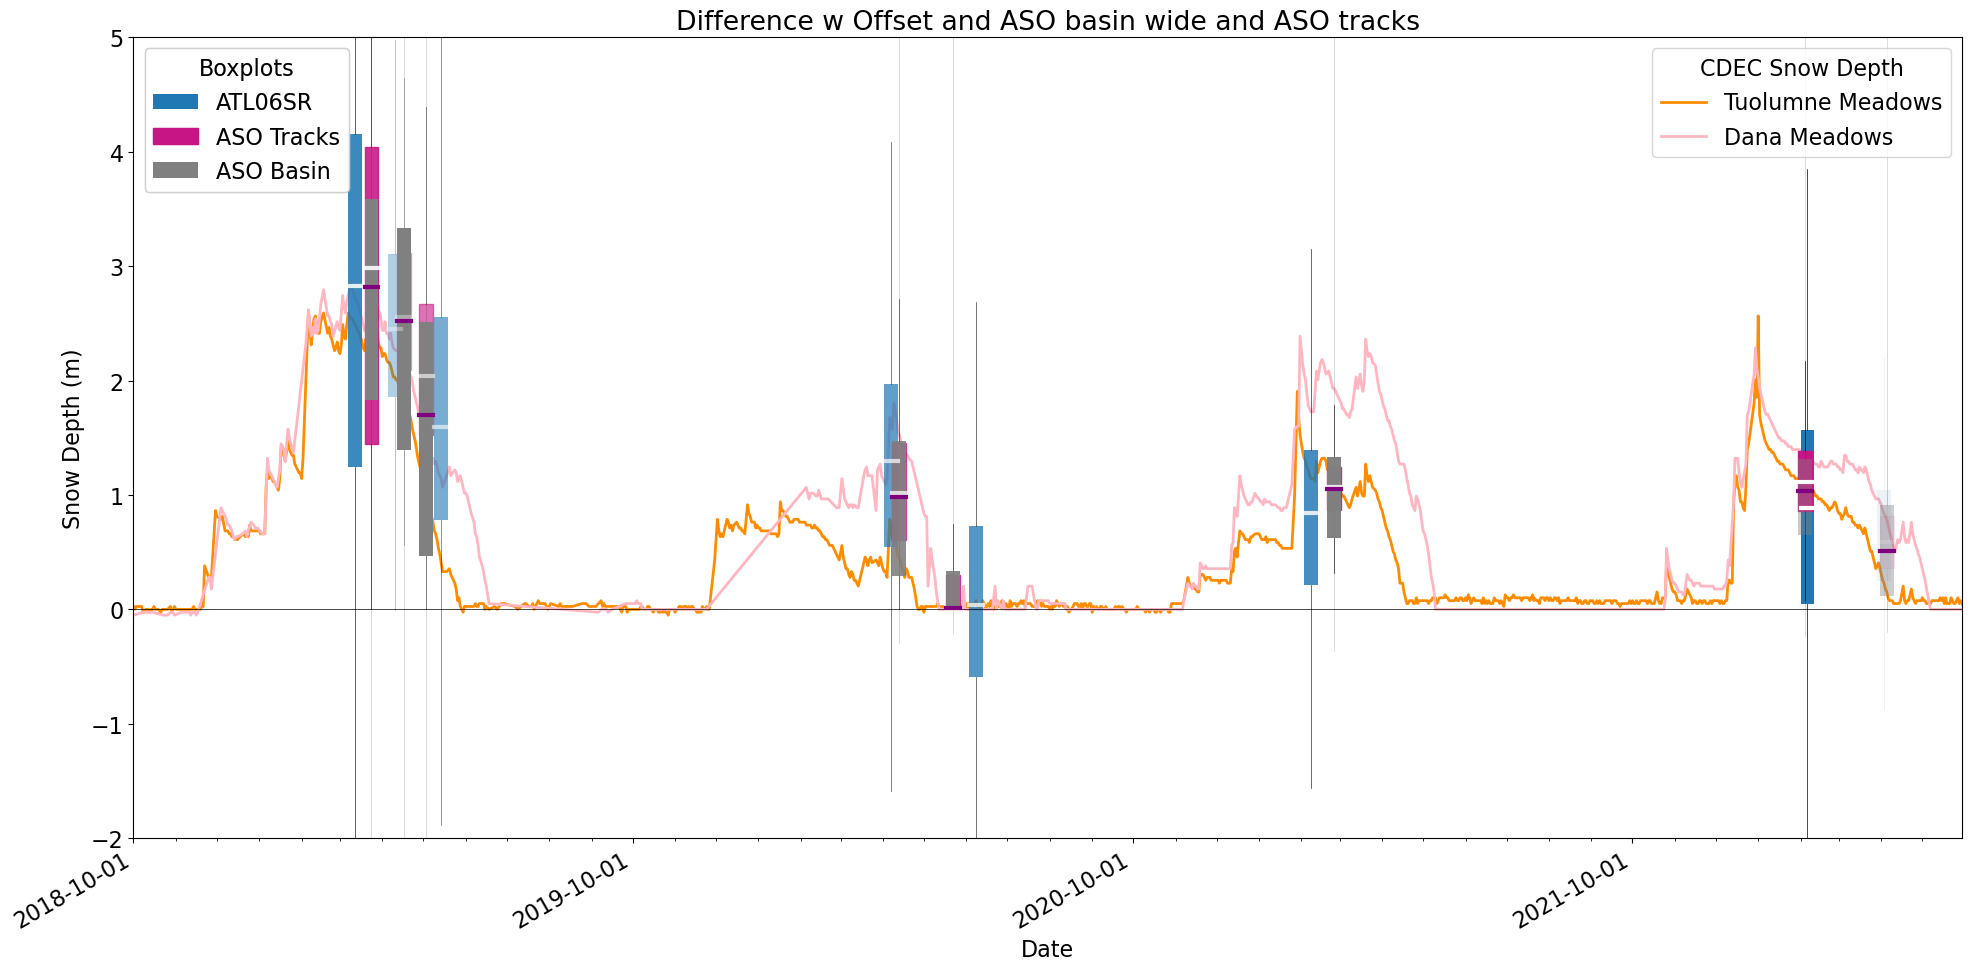

In [23]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=True, name = 'boxplots_asotracks_basin.jpeg')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

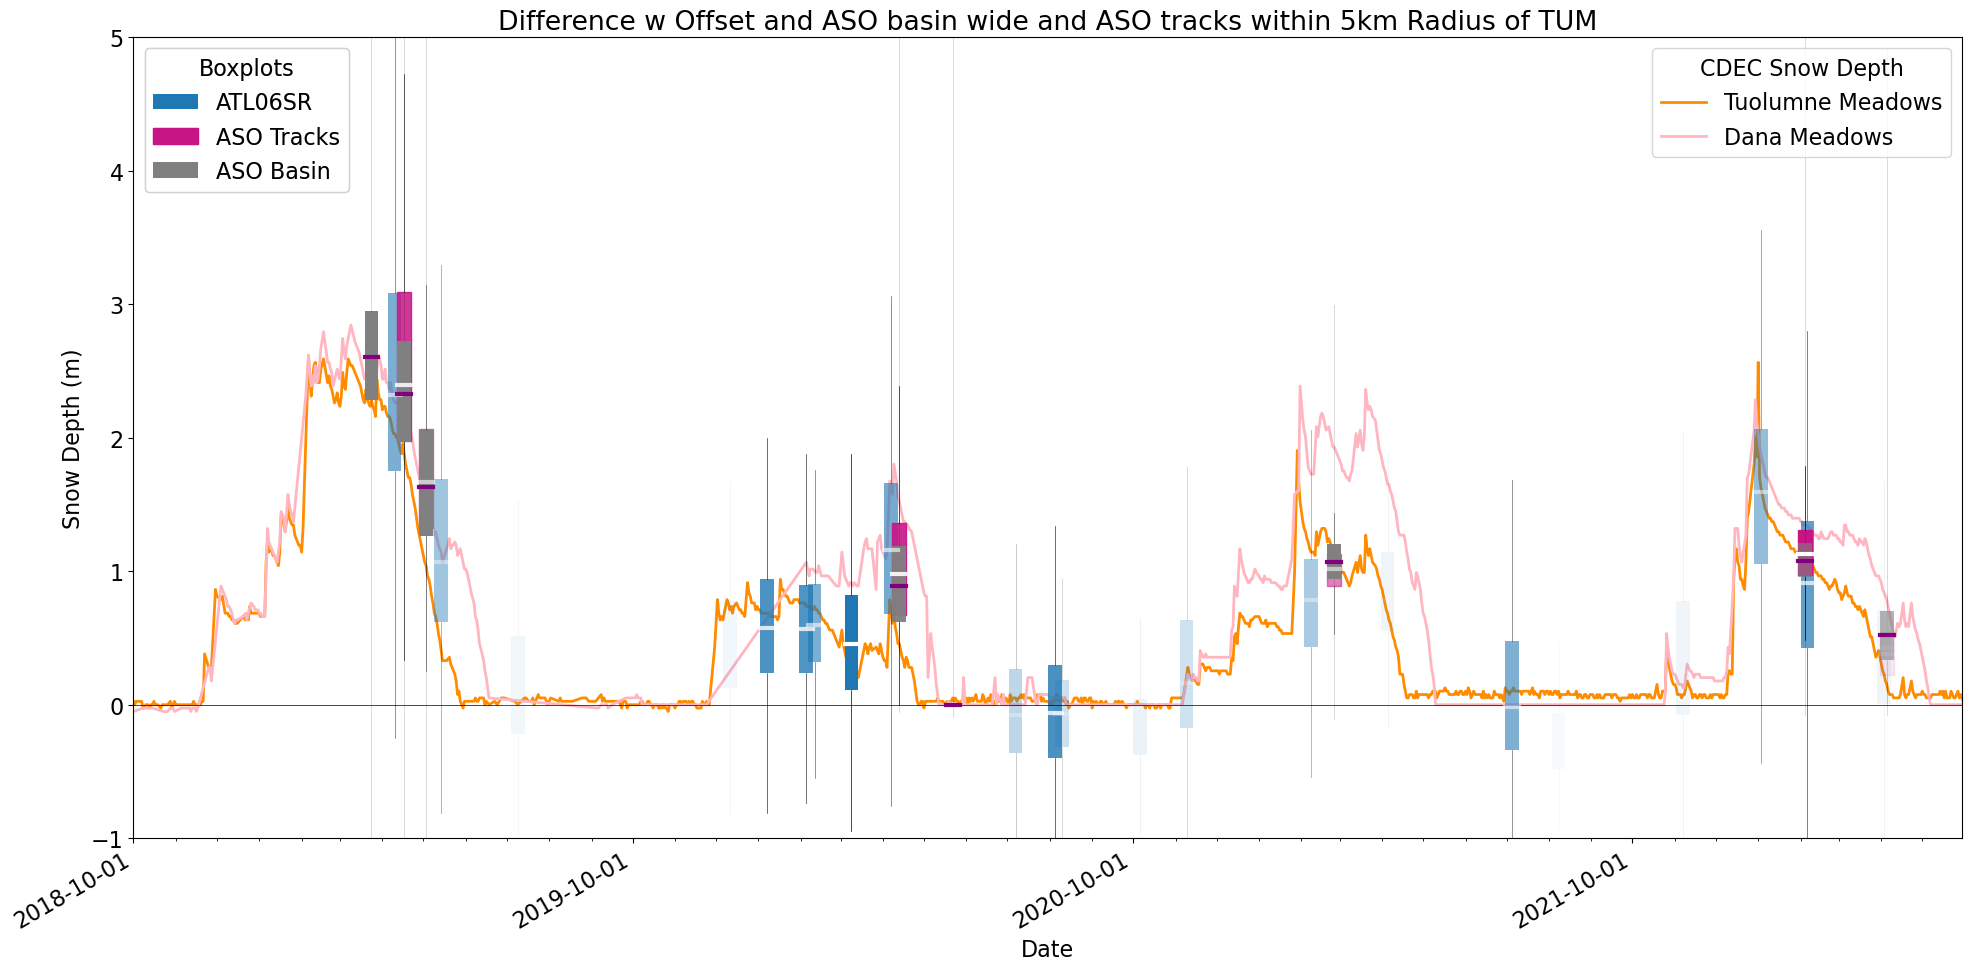

In [24]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[2, 'geometry'], rasterstats=True, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = 'boxplots_asotracks_basin_tum5.jpeg')

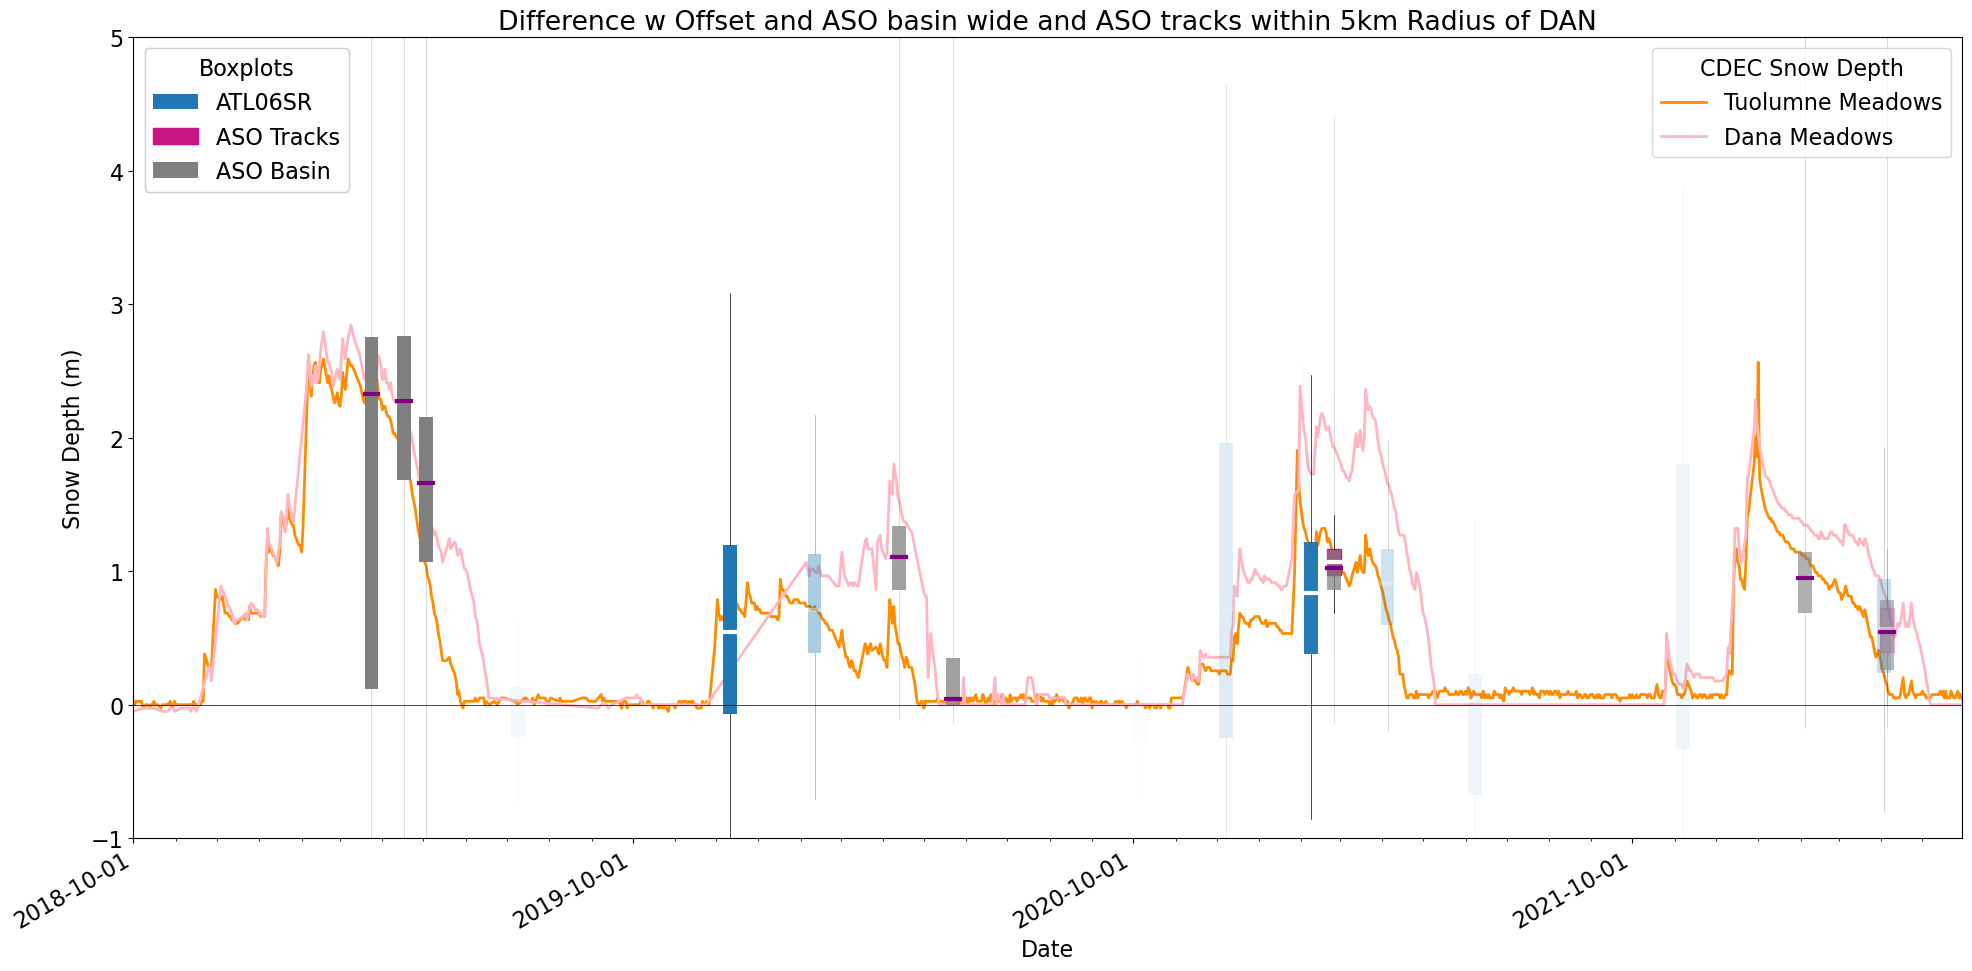

In [25]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=True, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = 'boxplots_asotracks_basin_dan5.jpeg')

## Old, less universal plotting functions:

In [157]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [158]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)